# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!mkdir data

mkdir: data: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

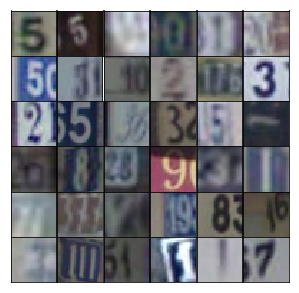

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [9]:
def conv_transpose(input_, filters, training ):
    """ Creates the convoluional layer with batch normalizatio and relu"""
    conv_layer = tf.layers.conv2d_transpose(input_, filters=filters, kernel_size=5, strides=2, padding = 'same' )
    conv_layer = tf.layers.batch_normalization(conv_layer, training= training)
    
    return tf.nn.leaky_relu(conv_layer)
    

In [10]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4,4,512))
        x1 = tf.layers.batch_normalization(x1, training = training)
        
        # the first conv_layer
        x2 = conv_transpose(x1, 256, training)
        
        x3 = conv_transpose(x2, 128, training)
        

        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x3,output_dim,kernel_size = 5, strides=2,padding = 'same' )
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [11]:
def conv_layer(input_, filters):
    """Builds the convolutional layers """
    layer = tf.layers.conv2d(input_, filters, kernel_size=5, strides = 2, use_bias=False)
    layer = tf.layers.batch_normalization(layer, training=True)
    return tf.nn.leaky_relu(layer)
    

In [12]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x,filters = 64,  kernel_size=5, strides = 2 , padding = 'same')
        x1 = tf.nn.leaky_relu(x1)
        
        x2 = conv_layer(x1, filters = 128)
        x3 = conv_layer(x2, filters = 256)
        
        
        x4 = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(x4, units = 1)
        out = tf.nn.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [13]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [15]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [16]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [17]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [18]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.002
batch_size = 64
epochs = 1
alpha = 0.01
beta1 = 0.9

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/1... Discriminator Loss: 3.1919... Generator Loss: 0.2017
Epoch 1/1... Discriminator Loss: 1.8231... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 2.0052... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.6984... Generator Loss: 1.2071
Epoch 1/1... Discriminator Loss: 1.7202... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.7297... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 2.1816... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.8575


/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


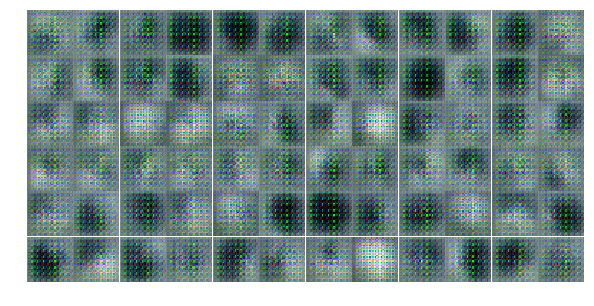

Epoch 1/1... Discriminator Loss: 2.1694... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 1.4094
Epoch 1/1... Discriminator Loss: 1.1954... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.6759... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.9556... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.5794... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.9396


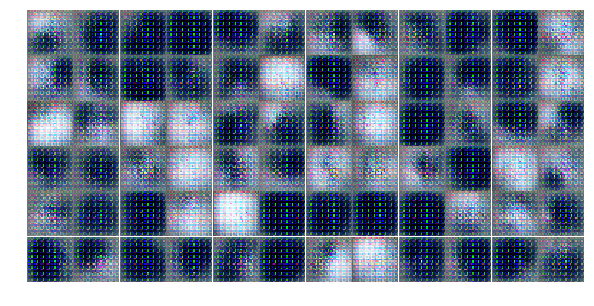

Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.5296
Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.6169... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.6062
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 1.0806
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.5553
Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.2600
Epoch 1/1... Discriminator Loss: 1.0834... Generator Loss: 1.1912
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.4178


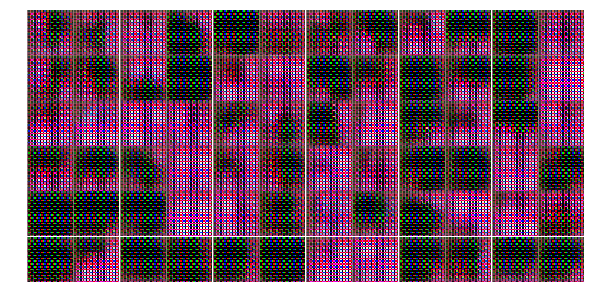

Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 1.0507
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 1.1485
Epoch 1/1... Discriminator Loss: 0.4262... Generator Loss: 1.6876
Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.1465
Epoch 1/1... Discriminator Loss: 0.5589... Generator Loss: 1.4842
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 1.7740
Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 1.2855
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 2.5160
Epoch 1/1... Discriminator Loss: 0.6687... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 0.7731... Generator Loss: 1.4930


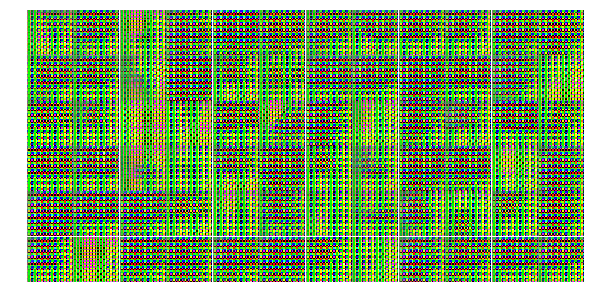

Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 1.5599
Epoch 1/1... Discriminator Loss: 0.6125... Generator Loss: 1.9341
Epoch 1/1... Discriminator Loss: 0.5745... Generator Loss: 1.4376
Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 1.9449
Epoch 1/1... Discriminator Loss: 0.4341... Generator Loss: 1.6433
Epoch 1/1... Discriminator Loss: 0.3665... Generator Loss: 1.4613
Epoch 1/1... Discriminator Loss: 0.3258... Generator Loss: 1.5205
Epoch 1/1... Discriminator Loss: 0.2535... Generator Loss: 1.8765
Epoch 1/1... Discriminator Loss: 0.4577... Generator Loss: 1.5922
Epoch 1/1... Discriminator Loss: 0.2265... Generator Loss: 2.7262


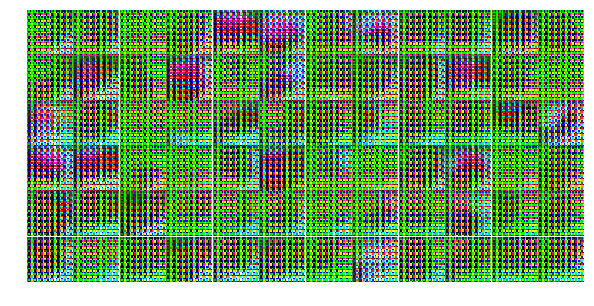

Epoch 1/1... Discriminator Loss: 0.3864... Generator Loss: 1.4661
Epoch 1/1... Discriminator Loss: 0.3201... Generator Loss: 1.4555
Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 0.0913... Generator Loss: 4.1234
Epoch 1/1... Discriminator Loss: 0.5604... Generator Loss: 2.5173
Epoch 1/1... Discriminator Loss: 0.2976... Generator Loss: 1.8748
Epoch 1/1... Discriminator Loss: 0.0766... Generator Loss: 3.3879
Epoch 1/1... Discriminator Loss: 0.3948... Generator Loss: 3.2159
Epoch 1/1... Discriminator Loss: 0.5296... Generator Loss: 1.5198
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 1.8629


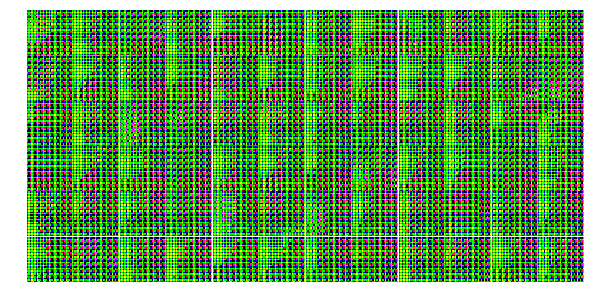

Epoch 1/1... Discriminator Loss: 0.1925... Generator Loss: 2.5909
Epoch 1/1... Discriminator Loss: 0.2862... Generator Loss: 2.3813
Epoch 1/1... Discriminator Loss: 0.1694... Generator Loss: 2.2373
Epoch 1/1... Discriminator Loss: 0.2654... Generator Loss: 2.0500
Epoch 1/1... Discriminator Loss: 0.1688... Generator Loss: 2.7009
Epoch 1/1... Discriminator Loss: 0.0509... Generator Loss: 4.0321
Epoch 1/1... Discriminator Loss: 0.0915... Generator Loss: 3.2186
Epoch 1/1... Discriminator Loss: 0.2004... Generator Loss: 3.6025
Epoch 1/1... Discriminator Loss: 0.0887... Generator Loss: 2.8587
Epoch 1/1... Discriminator Loss: 0.2217... Generator Loss: 2.4559


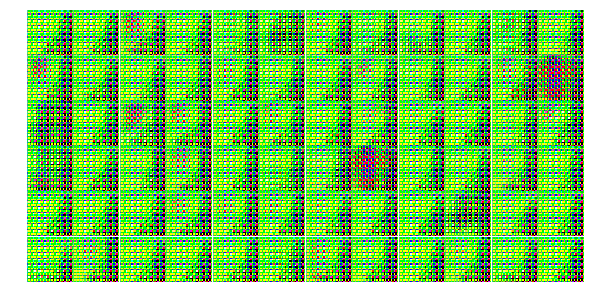

Epoch 1/1... Discriminator Loss: 0.0979... Generator Loss: 2.6635
Epoch 1/1... Discriminator Loss: 0.1289... Generator Loss: 2.6215
Epoch 1/1... Discriminator Loss: 0.4700... Generator Loss: 2.3056
Epoch 1/1... Discriminator Loss: 0.1256... Generator Loss: 2.4942
Epoch 1/1... Discriminator Loss: 0.1388... Generator Loss: 3.3976
Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 1.2972
Epoch 1/1... Discriminator Loss: 0.0860... Generator Loss: 3.6294
Epoch 1/1... Discriminator Loss: 0.0630... Generator Loss: 3.2993
Epoch 1/1... Discriminator Loss: 0.0702... Generator Loss: 3.7298
Epoch 1/1... Discriminator Loss: 0.0443... Generator Loss: 3.6386


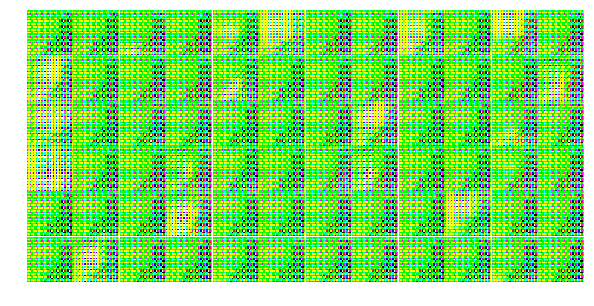

Epoch 1/1... Discriminator Loss: 0.0639... Generator Loss: 3.6573
Epoch 1/1... Discriminator Loss: 0.0470... Generator Loss: 3.4581
Epoch 1/1... Discriminator Loss: 0.0432... Generator Loss: 4.1190
Epoch 1/1... Discriminator Loss: 0.0305... Generator Loss: 3.7660
Epoch 1/1... Discriminator Loss: 0.0726... Generator Loss: 2.9444
Epoch 1/1... Discriminator Loss: 0.0547... Generator Loss: 4.0614
Epoch 1/1... Discriminator Loss: 0.3725... Generator Loss: 3.4017
Epoch 1/1... Discriminator Loss: 0.1191... Generator Loss: 3.2449
Epoch 1/1... Discriminator Loss: 0.1748... Generator Loss: 2.2054
Epoch 1/1... Discriminator Loss: 0.1053... Generator Loss: 3.1336


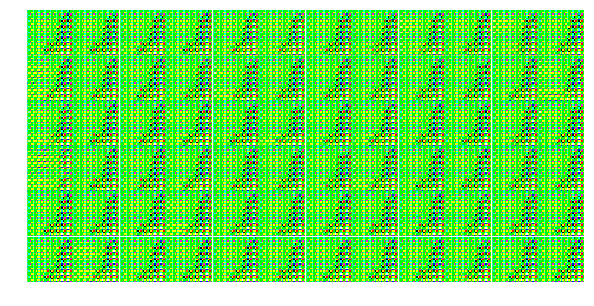

Epoch 1/1... Discriminator Loss: 0.3815... Generator Loss: 1.3004
Epoch 1/1... Discriminator Loss: 0.0416... Generator Loss: 4.6533
Epoch 1/1... Discriminator Loss: 0.0427... Generator Loss: 3.7743
Epoch 1/1... Discriminator Loss: 0.0821... Generator Loss: 3.2715
Epoch 1/1... Discriminator Loss: 0.0497... Generator Loss: 3.5125
Epoch 1/1... Discriminator Loss: 0.1534... Generator Loss: 3.8077
Epoch 1/1... Discriminator Loss: 0.1048... Generator Loss: 2.7384
Epoch 1/1... Discriminator Loss: 0.0898... Generator Loss: 2.8024
Epoch 1/1... Discriminator Loss: 0.2210... Generator Loss: 2.4188
Epoch 1/1... Discriminator Loss: 0.0618... Generator Loss: 3.7092


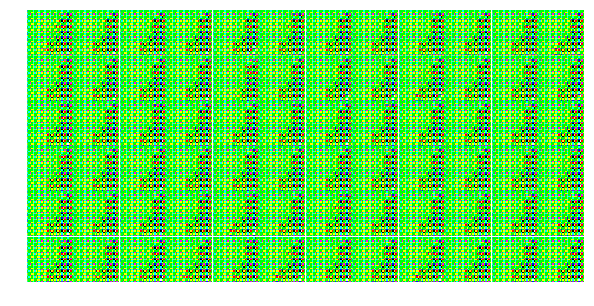

Epoch 1/1... Discriminator Loss: 0.3430... Generator Loss: 3.1526
Epoch 1/1... Discriminator Loss: 0.0527... Generator Loss: 3.5640
Epoch 1/1... Discriminator Loss: 0.1057... Generator Loss: 2.8069
Epoch 1/1... Discriminator Loss: 0.1056... Generator Loss: 2.4066
Epoch 1/1... Discriminator Loss: 0.0471... Generator Loss: 3.5081
Epoch 1/1... Discriminator Loss: 0.0540... Generator Loss: 3.3417
Epoch 1/1... Discriminator Loss: 0.0150... Generator Loss: 4.9323
Epoch 1/1... Discriminator Loss: 0.0275... Generator Loss: 4.3283
Epoch 1/1... Discriminator Loss: 0.0737... Generator Loss: 4.8173
Epoch 1/1... Discriminator Loss: 0.0269... Generator Loss: 4.0181


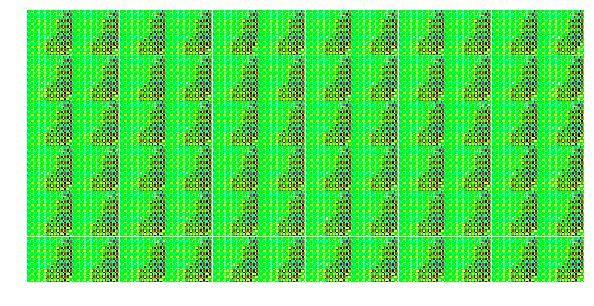

Epoch 1/1... Discriminator Loss: 0.0566... Generator Loss: 3.4514
Epoch 1/1... Discriminator Loss: 0.0137... Generator Loss: 5.1769
Epoch 1/1... Discriminator Loss: 0.0320... Generator Loss: 3.8299
Epoch 1/1... Discriminator Loss: 0.0411... Generator Loss: 3.8557


InvalidArgumentError: Input to reshape is a tensor with 10496 values, but the requested shape requires a multiple of 4096
	 [[Node: discriminator/Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](discriminator/LeakyRelu_2/Maximum, discriminator/Reshape/shape)]]

Caused by op 'discriminator/Reshape', defined at:
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1431, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/tornado/ioloop.py", line 760, in _run_callback
    ret = callback()
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 536, in <lambda>
    self.io_loop.add_callback(lambda : self._handle_events(self.socket, 0))
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-aa163e981298>", line 10, in <module>
    net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)
  File "<ipython-input-15-314dd314f2e8>", line 8, in __init__
    real_size[2], alpha=alpha)
  File "<ipython-input-13-50caf9ecf7cf>", line 10, in model_loss
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
  File "<ipython-input-12-5cb29641e8a9>", line 11, in discriminator
    x4 = tf.reshape(x3, (-1, 4*4*256))
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6113, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/Users/crivera5/.virtualenvs/aind/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 10496 values, but the requested shape requires a multiple of 4096
	 [[Node: discriminator/Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](discriminator/LeakyRelu_2/Maximum, discriminator/Reshape/shape)]]


In [19]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))